# DH-401: Digital Musicology semester project
---------------
## Predicting music popularity using DNNs - Milestone 3
-------------------

In [1]:
from zipfile import ZipFile
from tqdm import tqdm

from IPython import display
import librosa

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

import numpy as np

from scipy.stats import chisquare
from scipy.stats import shapiro

plt.rcParams['figure.figsize'] = (17, 5)

In [2]:
# Load metadata and features.
# Function based on: https://github.com/mdeff/fma/blob/master/utils.py
tracks = pd.read_csv('data/fma_metadata/tracks.csv', index_col=0, header=[0, 1])

COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
            ('track', 'genres'), ('track', 'genres_all')]
for column in COLUMNS:
    tracks[column] = tracks[column].map(ast.literal_eval)

COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
            ('album', 'date_created'), ('album', 'date_released'),
            ('artist', 'date_created'), ('artist', 'active_year_begin'),
            ('artist', 'active_year_end')]
for column in COLUMNS:
    tracks[column] = pd.to_datetime(tracks[column])

SUBSETS = ('small', 'medium', 'large')
try:
    tracks['set', 'subset'] = tracks['set', 'subset'].astype(
            'category', categories=SUBSETS, ordered=True)
except (ValueError, TypeError):
    # the categories and ordered arguments were removed in pandas 0.25
    tracks['set', 'subset'] = tracks['set', 'subset'].astype(
              pd.CategoricalDtype(categories=SUBSETS, ordered=True))

COLUMNS = [('track', 'genre_top'), ('track', 'license'),
            ('album', 'type'), ('album', 'information'),
            ('artist', 'bio')]
for column in COLUMNS:
    tracks[column] = tracks[column].astype('category')


tracks.shape

(106574, 52)

## Popularity measure

In [3]:
def log_transform(serie):
    return np.log((serie)+1)

In [4]:
POP_FEATURES = ["listens", "favorites", "comments"]

In [5]:
pop_df = tracks["track"][["date_created", "genre_top"]+POP_FEATURES]

# add informations collected at the "album level"
for pop_feat in POP_FEATURES:
    pop_df["album_"+pop_feat] = [count for count in tracks["album"][pop_feat]]

pop_df.sample(3)

,date_created,genre_top,listens,favorites,comments,album_listens,album_favorites,album_comments
track_id,,,,,,,,
13996,2009-05-27 13:15:10,NaN,1047,1,0,6930,1,0
137631,2016-05-21 06:04:49,Rock,2883,2,0,18069,1,0
133977,2016-03-11 13:33:57,Instrumental,7253,10,0,75573,3,1


### Not removing songs without album

In [6]:
# add informations collected at the "album level"
for pop_feat in POP_FEATURES:
    # 0 instead of default value -1
    pop_df["album_"+pop_feat] = [count if count > 0 else 0
                                 for count in tracks["album"][pop_feat]]

In [7]:
# without `interest` but with album scores
X = pop_df[POP_FEATURES+["album_"+pop_feat for pop_feat in POP_FEATURES]].copy()

for pop_feat in X.columns:
    # using log transform for the pca
    X[pop_feat] = log_transform(X[pop_feat])

pca = PCA(n_components=1, svd_solver="full").fit(X)
#computing popularity score as a 1D projection of the popularity features
pop_df["pop_score"] = pca.transform(X) 

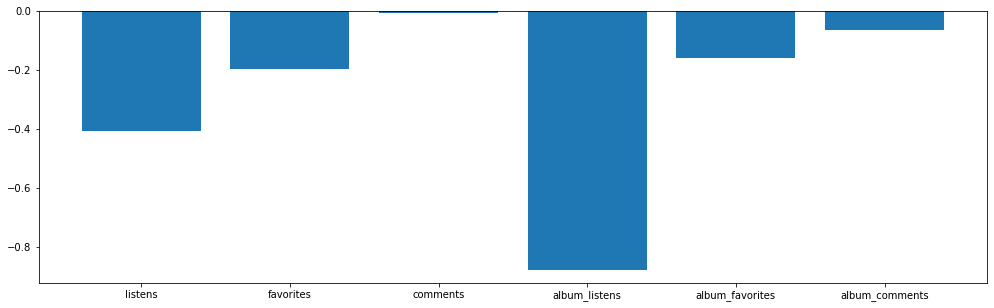

In [8]:
plt.bar(X.columns
        , (pca.components_)[0]
       )
plt.show()
# negative coefficients => min pop score = higher popularity (can be inverted)

/Users/nmm/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


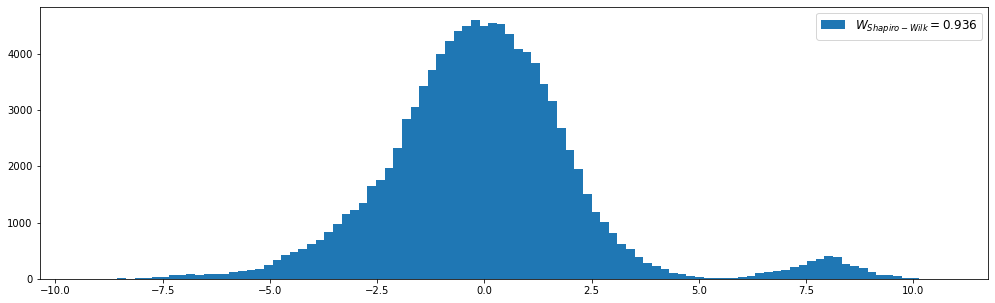

In [9]:
W, p_val = shapiro(pop_df.pop_score)

plt.hist(pop_df.pop_score, bins=100, label=r"$W_{Shapiro-Wilk}"+"={0:.3f}$".format(W))
plt.legend(fontsize=12)
plt.show()
# second small peak that i think comes from songs without album informations

In [10]:
pop_df.sample(3)

,date_created,genre_top,listens,favorites,comments,album_listens,album_favorites,album_comments,pop_score
track_id,,,,,,,,,
35342,2010-09-08 21:28:45,Electronic,619,3,0,4956,1,0,0.302781
121736,2015-06-22 15:33:41,Pop,2402,4,0,19991,2,0,-1.575789
22150,2009-12-14 12:21:03,Experimental,2067,0,0,3110,0,0,0.604323


### Removing songs without album

In [18]:
# add informations collected at the "album level"
for pop_feat in POP_FEATURES:
    pop_df["album_"+pop_feat] = [count for count in tracks["album"][pop_feat]]

In [19]:
no_album = pop_df.album_listens < 0
print("{0:.2f}% songs have no album.".format(100*np.sum(no_album)/len(pop_df)))

3.31% songs have no album.


In [20]:
# keeping only songs with album informations
pop_df = pop_df[~no_album].copy()
pop_df.shape

(103045, 9)

In [21]:
# without `interest` but with album scores
X = pop_df[POP_FEATURES+["album_"+pop_feat for pop_feat in POP_FEATURES]].copy()

for pop_feat in X.columns:
    # using log transform for the pca
    X[pop_feat] = log_transform(X[pop_feat])

pca = PCA(n_components=1, svd_solver="full").fit(X)
#computing popularity score as a 1D projection of the popularity features
pop_df["pop_score"] = pca.transform(X) 

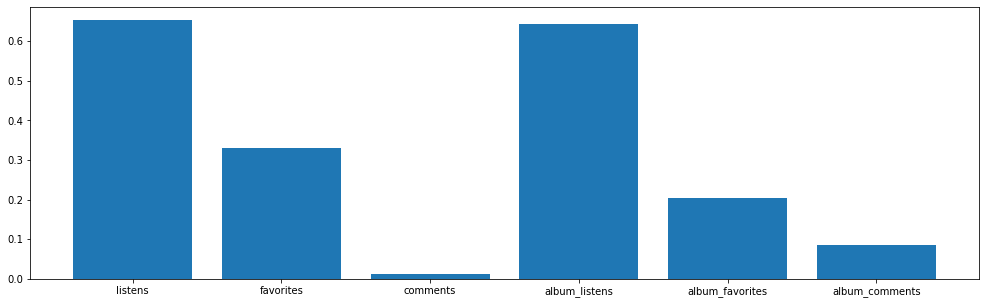

In [22]:
plt.bar(X.columns
        , (pca.components_)[0]
       )
plt.show()

/Users/nmm/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


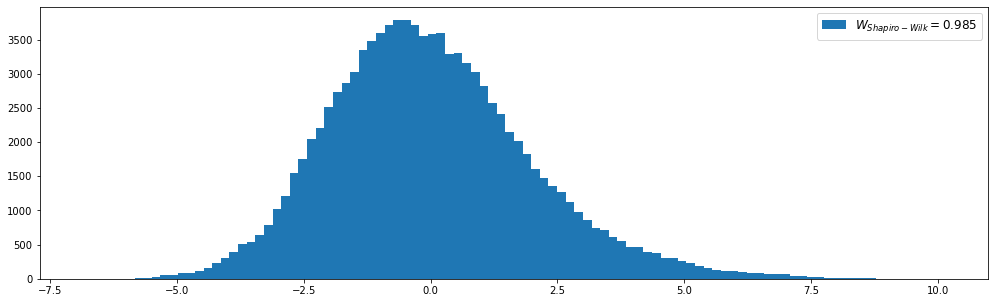

In [23]:
W, p_val = shapiro(pop_df.pop_score)

plt.hist(pop_df.pop_score, bins=100, label=r"$W_{Shapiro-Wilk}"+"={0:.3f}$".format(W))
plt.legend(fontsize=12)
plt.show()

In [24]:
# as the distribution is ~ normal (shapiro close to 1), standardize the score (z-score normalization)
pop_df["pop_score"] = (pop_df["pop_score"]-np.mean(pop_df["pop_score"]))/(np.std(pop_df["pop_score"]))

In [25]:
pop_df.sample(3)

,date_created,genre_top,listens,favorites,comments,album_listens,album_favorites,album_comments,pop_score
track_id,,,,,,,,,
112966,2015-01-03 11:56:51,NaN,6071,6,0,21321,0,0,1.046554
29481,2010-05-03 07:35:06,NaN,424,0,0,9891,0,0,-0.398904
1982,2008-11-26 03:16:59,Experimental,106,0,0,606,1,0,-1.684165
